In [2]:
import sys
sys.path.insert(0, "../..")

from src.models.build import summary
from src.data import data_tools, make_dataset
from src.models import tokenizer 

import trax
from trax import layers as tl
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape
from trax.shapes import signature

import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline


/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


We will first pull up the code we have used earlier to create a streamer

In [3]:
import gin
gin.parse_config_file("preprocessor.gin")

data_dir = "../../data/raw"
# use the imdb text data
trainpaths, testpaths = make_dataset.get_imdb_data(data_dir)
traindataset = data_tools.TextDataset(paths=trainpaths)
testdataset = data_tools.TextDataset(paths=testpaths)

# build a corpus and vocab
corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=10000)

# use the preprocessor for cleaning
preprocessor = tokenizer.Preprocessor(vocab=v, clean=tokenizer.clean)

# wrap it up inside a streamer
trainstream = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()

teststream = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


2022-06-07 12:20:37.349 | INFO     | src.data.make_dataset:get_imdb_data:96 - ../../data/raw/aclImdb already exists, skipping download
100%|██████████| 25000/25000 [00:08<00:00, 3083.14it/s]
2022-06-07 12:21:00.721 | INFO     | src.models.tokenizer:build_vocab:27 - Found 79808 tokens


In [7]:
X, y = next(trainstream)
type(X), type(y)


(torch.Tensor, torch.Tensor)

This works. However, we will have PyTorch Tensors.

We could rewrite everything, but we could also cast it to numpy, because trax works fine with numpy.

In [5]:
def Cast():
    def f(generator):
        for x, y in generator:
            yield x.numpy(), y.numpy()

    return lambda g: f(g)


We need to write a functionwrapper, that returns a function that has a generator g as input.
We can yield a first sample from the generator, cast it to numpy, and yield that again. 

This way we will have chained two generators. We can use `trax.data.Serial` to chain generators.

In [9]:
data_pipeline = trax.data.Serial(Cast())
trainpipe = data_pipeline(trainstream)
testpipe = data_pipeline(teststream)
X, y = next(trainpipe)
type(X), type(y)


(numpy.ndarray, numpy.ndarray)

In the GRU model, the GRU layer will output (batch, sequence, dimension).
We could do two thing here:
1. Simply take the last timestep of the sequence
2. Take the average of the sequence

Let's implement both as a layer:

In [10]:
def Last():
    return tl.Fn("Last", lambda x: x[:, -1, :], n_out=1)

def AvgLast():
    return tl.Fn("AvgLast", lambda x: x.mean(axis=-1), n_out=1)

We can wrap this all into a model

In [11]:
@assert_shape("bs->bd")
def EmbGRU(vocab_size: int, d_feature: int, d_out: int):
    model = cb.Serial(
        tl.Embedding(vocab_size=vocab_size, d_feature=d_feature),
        tl.GRU(n_units=d_feature),
        tl.BatchNorm(),
        AvgLast(),
        tl.Dense(d_out),
    )
    return model


And create a model

In [12]:
model = EmbGRU(vocab_size=len(v), d_feature=128, d_out=2)
model.init_weights_and_state(signature(X))
summary(model, X)


/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3710: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


layer                   input                dtype     output               dtype 
(0) Embedding_10002_128 (32, 100)          ( int32 ) | (32, 100, 128)     (float32)
(1) GRU_128             (32, 100, 128)     (float32) | (32, 100, 128)     (float32)
(2) BatchNorm           (32, 100, 128)     (float32) | (32, 100, 128)     (float32)
(3) AvgLast             (32, 100, 128)     (float32) | (32, 100)          (float32)
(4) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)


ShapeDtype{shape:(32, 2), dtype:float32}

If we want to train, we will need a loss function. Let's pick the CategoryCrossEntropy, which is the same as the CrossEntropy we have been using with PyTorch.

In [13]:
yhat = model(X)
loss = tl.CategoryCrossEntropy()
loss((yhat, y))


DeviceArray(0.69606143, dtype=float32)

Also, let's add accuracy

In [14]:
acc = tl.CategoryAccuracy()
acc((yhat, y))


DeviceArray(0.53125, dtype=float32)

And let's check the accuracy to be sure this does what we want

In [15]:
import jax.numpy as jnp

pred = jnp.argmax(yhat, axis=-1)
correct = jnp.equal(pred, y)
correct


DeviceArray([False,  True, False,  True, False, False,  True, False,
              True,  True,  True,  True, False,  True, False, False,
             False,  True,  True, False,  True, False,  True, False,
              True, False,  True,  True, False, False,  True,  True],            dtype=bool)

In [16]:
correct.sum() / len(y)


DeviceArray(0.53125, dtype=float32)

So that works as expected.

We have been talking about learning rate schedules. Trax has implemented some of them too.

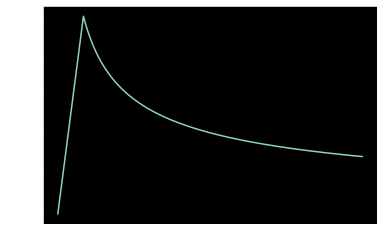

In [17]:
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay

lr = warmup_and_rsqrt_decay(100, 0.01)
steps = jnp.arange(1200)
y = [lr(x) for x in steps]
plt.plot(steps, y)


To train everything, we can wrap this in a train and eval task, and combine that in a loop.

In [19]:
from trax.supervised import training

model = EmbGRU(vocab_size=len(v), d_feature=128, d_out=2)
log_dir = "../../models/trax"
log_dir = data_tools.dir_add_timestamp(log_dir)

train_task = training.TrainTask(
    labeled_data=trainpipe,
    loss_layer=tl.CategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(),
    lr_schedule=lr
)

eval_task = training.EvalTask(
    labeled_data=testpipe, metrics=[tl.CategoryAccuracy(), tl.CategoryCrossEntropy()], n_eval_batches=25
)

loop = training.Loop(
    model,
    train_task,
    eval_tasks=[eval_task],
    output_dir=log_dir,
)


2022-06-07 12:31:21.528 | INFO     | src.data.data_tools:dir_add_timestamp:213 - Logging to ../../models/trax/20220607-1231


Trax expects streamers. They can go on forever, so let's test a 1000 batches: 

In [20]:
loop.run(1000)



Step      1: Total number of trainable weights: 1379148
Step      1: Ran 1 train steps in 2.92 secs
Step      1: train CategoryCrossEntropy |  0.70305592
Step      1: eval      CategoryAccuracy |  0.50625000
Step      1: eval  CategoryCrossEntropy |  0.71088120

Step    100: Ran 99 train steps in 6.31 secs
Step    100: train CategoryCrossEntropy |  0.66260082
Step    100: eval      CategoryAccuracy |  0.72875000
Step    100: eval  CategoryCrossEntropy |  0.52359872

Step    200: Ran 100 train steps in 6.58 secs
Step    200: train CategoryCrossEntropy |  0.49283358
Step    200: eval      CategoryAccuracy |  0.76250000
Step    200: eval  CategoryCrossEntropy |  0.47756310

Step    300: Ran 100 train steps in 6.30 secs
Step    300: train CategoryCrossEntropy |  0.44162586
Step    300: eval      CategoryAccuracy |  0.77500000
Step    300: eval  CategoryCrossEntropy |  0.45299261

Step    400: Ran 100 train steps in 6.31 secs
Step    400: train CategoryCrossEntropy |  0.40324441
Step    40

It is pretty easy to add an additional 200 steps. Trax will pick up where it left.

In [21]:
loop.run(200)


Step   1100: Ran 100 train steps in 6.31 secs
Step   1100: train CategoryCrossEntropy |  0.37939116
Step   1100: eval      CategoryAccuracy |  0.79125000
Step   1100: eval  CategoryCrossEntropy |  0.45956976

Step   1200: Ran 100 train steps in 6.42 secs
Step   1200: train CategoryCrossEntropy |  0.34051177
Step   1200: eval      CategoryAccuracy |  0.80500000
Step   1200: eval  CategoryCrossEntropy |  0.44571803


And we can see that our model works as expected

In [26]:
X, y = next(testpipe)
yhat = model(X)
acc = tl.CategoryAccuracy()
acc((yhat, y))

DeviceArray(0.8125, dtype=float32)